## Спортивный анализ данных. Платформа Kaggle
### Тюнинг гиперпараметров, построение ансамблей алгоритмов.

### Практическое задание 6.

* __Задание 1:__ Обучить алгоритмы LightGBM и XGBoost, получить OOF прогнозы, оценить корреляцию прогнозов на обучающей выборке. Применить модели на тестовую выборку и оценить корреляцию.

* __Задание 2:__ Усреднить прогнозы с помощью арифмитического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации.

* __Задание 3:__ Обучить CatBoost, получить OOF прогнозы и выполнить задание 1 для трех моделей.

* __Задание 4:__ Выполнить задание 2 для трех моделей.
* __Задание 5:__ (опция) Объединить OOF-прогнозы для трех моделей и обучить алгоритм Логистической регрессии (и любой другой, на ваше усмотрение). Сделать выводы о достигаемом качестве, сравнить достигаемое качество с качеством отдельных моделей и моделей, полученных в п.2 и п.4.

* __Задание 6:__ (опция) Обучить алгоритмRandomForest (желательно подтюнить параметры) и добавить к построенным ранее моделям. Выполнить задание 5.

https://www.kaggle.com/c/geekbrains-competitive-data-analysis/overview

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.metrics import roc_auc_score

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import RandomForestClassifier

from scipy.stats.mstats import gmean

import shap
from sklearn.inspection import permutation_importance

from pprint import pprint
import gc

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

### 1. Пути к директориям и файлам.

In [3]:
PATH = 'C:/Users/ASER/Desktop/GeekBrains/Kaggle/project/'

TRAIN_DATASET_PATH = PATH + 'train.csv.zip'
TEST_DATASET_PATH = PATH + 'test.csv.zip'

APPLICATIONS_PATH = PATH + 'applications_history.csv.zip'
CLIENT_PATH = PATH + 'client_profile.csv.zip'
PAYMENTS_PATH = PATH + 'payments.csv.zip'
BKI_PATH = PATH + 'bki.csv.zip'

SAMPLE_PATH = PATH + 'sample_submit.csv.zip'

### 2. Загрузка данных <a name = 'load_data'></a>

In [4]:
train = pd.read_csv(TRAIN_DATASET_PATH)
print('train.shape', train.shape)
train.head(2)

train.shape (110093, 3)


,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
0,123687442,0,Cash
1,123597908,1,Cash


In [5]:
TARGET_NAME = 'TARGET'

In [6]:
test = pd.read_csv(TEST_DATASET_PATH)
print('test.shape', test.shape)
test.head(2)

test.shape (165141, 2)


,APPLICATION_NUMBER,NAME_CONTRACT_TYPE
0,123724268,Cash
1,123456549,Cash


In [7]:
clients = pd.read_csv(CLIENT_PATH)
print('clients', clients.shape)
clients.head(2)

clients (250000, 24)


,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,...,2.0,0.329471,0.236315,0.678568,0.0,0.0,0.0,0.0,1.0,2.0
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,...,2.0,NaN,0.442295,0.802745,0.0,0.0,0.0,0.0,1.0,1.0


In [8]:
applications = pd.read_csv(APPLICATIONS_PATH)
print('applications', applications.shape)
applications.head(2)

applications (1670214, 26)


,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,NAME_CONTRACT_STATUS,DAYS_DECISION,...,NAME_PRODUCT_TYPE,SELLERPLACE_AREA,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,49298709,123595216,NaN,1730.430,17145.0,17145.0,0.0,17145.0,Approved,73,...,XNA,35,12.0,middle,365243.0,42.0,300.0,42.0,37.0,0.0
1,50070639,123431468,Cash,25188.615,607500.0,679671.0,NaN,607500.0,Approved,164,...,x-sell,-1,36.0,low_action,365243.0,134.0,916.0,365243.0,365243.0,1.0


In [9]:
bki = pd.read_csv(BKI_PATH)
print('bki', bki.shape)
bki.head(2)

bki (945234, 17)


,APPLICATION_NUMBER,BUREAU_ID,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,123538884,5223613,Active,currency 1,718.0,0,377.0,NaN,19386.81,0,675000.00,320265.495,0.0,0.0,Consumer credit,39.0,NaN
1,123436670,6207544,Closed,currency 1,696.0,0,511.0,511.0,0.00,0,93111.66,0.000,0.0,0.0,Consumer credit,505.0,NaN


In [10]:
payments = pd.read_csv(PAYMENTS_PATH)
print('payments', payments.shape)
payments.head(2)

payments (1023932, 8)


,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,49011181,123664960,1.0,5,1002.0,1015.0,12156.615,12156.615
1,48683432,123497205,1.0,13,442.0,432.0,18392.535,10047.645


### 3. Формирование базы данных

#### Разделение признаков на количественные и категориальные

In [11]:
def feature_classification(data):
    CATEGORICAL_FEATURE_NAMES = data.dtypes[data.dtypes == "object"].index.tolist()
    NUMERICAL_FEATURE_NAMES = [i for i in data.columns if i not in CATEGORICAL_FEATURE_NAMES]
    NUMERICAL_FEATURE_NAMES.remove(TARGET_NAME)
    
    return NUMERICAL_FEATURE_NAMES, CATEGORICAL_FEATURE_NAMES

#### Добавление к данным частот категориальных признаков

In [12]:
def get_frequencies(data, encode_list):
    NEW_FEATURES_FREQUENCIES = []
    for feature in encode_list:        
        new_name = feature + '_freq'
        NEW_FEATURES_FREQUENCIES.append(new_name)
        
        a = data[feature].value_counts()
        if feature == 'BUREAU_ID':
            for i in range(1, 15):
                ind = a[a.values == i].keys().astype(int)
                data.loc[data[feature].isin(ind), new_name] = len(ind)
            ind_ = a[a.values >= 15].keys().astype(int)
            data.loc[data[feature].isin(ind_), new_name] = len(ind)
        elif feature == 'APPLICATION_NUMBER':
            for i in range(1, 20):
                ind = a[a.values == i].keys().astype(int)
                data.loc[data[feature].isin(ind), new_name] = len(ind)
            ind_ = a[a.values >= 20].keys().astype(int)
            data.loc[data[feature].isin(ind_), new_name] = len(ind)
        else:
            for key in a.keys():    
                data.loc[data[feature] == key, new_name] = a[key]
        
            
    return data, NEW_FEATURES_FREQUENCIES

#### Обработка категориальных признаков для LightGBM API

In [13]:
def ordinal_encoding_lgb(data, encode_list):
    CATEGORICAL_FEATURE_NAMES_lgb = []
    for feature in encode_list:
        lgb_feature = feature + '_lgb'
        CATEGORICAL_FEATURE_NAMES_lgb.append(lgb_feature)
        
        for ind, level in enumerate(data[feature].unique()):
            data.loc[data[feature] == level, lgb_feature] = ind
            
    return data, CATEGORICAL_FEATURE_NAMES_lgb

#### clients

In [14]:
def create_client_profile_features(X: pd.DataFrame, copy: bool = True) -> pd.DataFrame:
    """
    Создание признаков на основе профиля клиентов.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков с исходным профилем клиента.

    copy: bool, optional, default = True
        Флаг использования копии датафрейма X.
        Опциональный параметр, по умолчанию, равен True.

    Returns
    -------
    X_transformed: pandas.core.frame.DataFrame
        Расширенная матрица признаков с профилем клиентов.

    """
    if copy:
        X = X.copy()

    X["DAYS_ON_LAST_JOB"] = X["DAYS_ON_LAST_JOB"].replace(365243, np.nan)
    bki_flags = [flag for flag in X.columns if "AMT_REQ_CREDIT_BUREAU" in flag]
    X["bki_requests_count"] = X[bki_flags].sum(axis=1)
    X["bki_kurtosis"] = X[bki_flags].kurtosis(axis=1)

    X["external_scoring_prod"] = X["EXTERNAL_SCORING_RATING_1"] *\
                                 X["EXTERNAL_SCORING_RATING_2"] * X["EXTERNAL_SCORING_RATING_3"]
    X["external_scoring_weighted"] = X.EXTERNAL_SCORING_RATING_1 * 2 +\
                                     X.EXTERNAL_SCORING_RATING_2 * 1 + X.EXTERNAL_SCORING_RATING_3 * 3

    for function_name in ["min", "max", "mean", "nanmedian", "var"]:
        feature_name = "external_scoring_rating_{}".format(function_name)
        X[feature_name] = eval("np.{}".format(function_name))(
            X[["EXTERNAL_SCORING_RATING_1", "EXTERNAL_SCORING_RATING_2", "EXTERNAL_SCORING_RATING_3"]], axis=1
        )

    # Отношение между основными фин. показателями
    X['ratio_credit_to_annuity'] = X['AMOUNT_CREDIT'] / X['AMOUNT_ANNUITY']
    X["ratio_annuity_to_salary"] = X['AMOUNT_ANNUITY'] / X['TOTAL_SALARY']
    X['ratio_credit_to_salary'] = X['AMOUNT_CREDIT'] / X['TOTAL_SALARY']
    X["total_salary_net"] = X["TOTAL_SALARY"] - X["AMOUNT_ANNUITY"]

    # Отношение фин. показателей к возрасту и временным фичам
    X["ratio_annuity_to_age"] = X["AMOUNT_ANNUITY"] / X["AGE"]
    X["ratio_credit_to_age"] = X["AMOUNT_CREDIT"] / X["AGE"]
    X["ratio_salary_to_age"] = X["TOTAL_SALARY"] / X["AGE"]
    X["ratio_salary_to_experience"] = X["TOTAL_SALARY"] / X["DAYS_ON_LAST_JOB"]
    X["ratio_credit_to_experience"] = X["AMOUNT_CREDIT"] / X["DAYS_ON_LAST_JOB"]
    X["ratio_annuity_to_experience"] = X["AMOUNT_ANNUITY"] / X["DAYS_ON_LAST_JOB"]

    # Отношение врменных признаков
    X["ratio_age_to_experience"] = X["AGE"] / X["DAYS_ON_LAST_JOB"]
    X["product_salary_and_region_population"] = X["TOTAL_SALARY"] * X["REGION_POPULATION"]
    X["ratio_car_to_experience"] = X["OWN_CAR_AGE"] / X["DAYS_ON_LAST_JOB"]
    X["ratio_car_to_age"] = X["OWN_CAR_AGE"] / X["AGE"]

    # Произведение фин. показателей кредита на вероятность дефолта
    # Такая штука называется математическим ожиданием дефолта или ожидаемыми потерями
    X["expected_total_loss_1"] = X["EXTERNAL_SCORING_RATING_1"] * X["AMOUNT_CREDIT"]
    X["expected_total_loss_2"] = X["EXTERNAL_SCORING_RATING_2"] * X["AMOUNT_CREDIT"]
    X["expected_total_loss_3"] = X["EXTERNAL_SCORING_RATING_3"] * X["AMOUNT_CREDIT"]
    X["expected_monthly_loss_1"] = X["EXTERNAL_SCORING_RATING_1"] * X["AMOUNT_ANNUITY"]
    X["expected_monthly_loss_2"] = X["EXTERNAL_SCORING_RATING_2"] * X["AMOUNT_ANNUITY"]
    X["expected_monthly_loss_3"] = X["EXTERNAL_SCORING_RATING_3"] * X["AMOUNT_ANNUITY"]    
    
    X['NAME_CONTRACT_TYPE'] = np.where(X['NAME_CONTRACT_TYPE'] == 'Cash', 0, 1)
    
    # Композитные признаки
    X['GENDER'] = np.where(X['GENDER'] == 'F', 0, 1)
    X['EDUCATION_LEVEL'] = np.where(X['EDUCATION_LEVEL'].isin(['Higher education', 
                                                               'Academic degree']), 1, 0)
    X['FAMILY_STATUS'] = np.where(X['FAMILY_STATUS'].isin(['Married', 'Widow']), 1, 0)
    X['FAMILY_SIZE'] = np.where(X['FAMILY_SIZE'].isin([1, 2]), 0, 1)    
    X['AMT_REQ_CREDIT_BUREAU_MON'] = np.where(X['AMT_REQ_CREDIT_BUREAU_MON'] == 0, 0, 1)
    X['AMT_REQ_CREDIT_BUREAU_QRT'] = np.where(X['AMT_REQ_CREDIT_BUREAU_QRT'] == 0, 0, 1) 
    X['CHILDRENS'] = np.where(X['CHILDRENS'] == 0, 0, 1)
    
    X.loc[:, 'gender_education'] = X.loc[:, ['GENDER', 'EDUCATION_LEVEL']].\
                   apply(lambda x: ''.join(str(x.values))[1:-1].replace("'", ""), axis=1)
    X.loc[:, 'family_status_size'] = X.loc[:, ['FAMILY_STATUS', 'FAMILY_SIZE']].\
                   apply(lambda x: ''.join(str(x.values))[1:-1].replace("'", ""), axis=1)    
    X.loc[:, 'AMT_REQ_CREDIT_BUREAU_mon_qtr'] = X.loc[:, ['AMT_REQ_CREDIT_BUREAU_MON', 
                                                          'AMT_REQ_CREDIT_BUREAU_QRT']].\
                   apply(lambda x: ''.join(str(x.values))[1:-1].replace("'", ""), axis=1)
    X.loc[:, 'children_phone'] = X.loc[:, ['CHILDRENS', 'FLAG_PHONE']].\
                   apply(lambda x: ''.join(str(x.values))[1:-1].replace("'", ""), axis=1)
    
    X.drop(['GENDER', 'EDUCATION_LEVEL',
            'FAMILY_STATUS', 'FAMILY_SIZE',
            'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
            'CHILDRENS', 'FLAG_PHONE', 'FLAG_EMAIL'], axis=1, inplace=True)
    
    return X

In [15]:
df = pd.concat([train, test], axis=0)
data = pd.merge(df, clients, how='left', on='APPLICATION_NUMBER')
data = create_client_profile_features(data)

NUMERICAL_FEATURE_NAMES, CATEGORICAL_FEATURE_NAMES = feature_classification(data)
 
data, NEW_FEATURES_FREQUENCIES = get_frequencies(data, CATEGORICAL_FEATURE_NAMES)
NUMERICAL_FEATURE_NAMES += NEW_FEATURES_FREQUENCIES

data, CATEGORICAL_FEATURE_NAMES_lgb = ordinal_encoding_lgb(data, CATEGORICAL_FEATURE_NAMES)

data.shape

(275234, 58)

#### bki

In [16]:
data_bki = pd.merge(df, bki[~(bki['CREDIT_ACTIVE'] == 'Closed')], 
                    how='left', on = 'APPLICATION_NUMBER')

NUMERICAL_FEATURE_NAMES_bki, CATEGORICAL_FEATURE_NAMES_bki = feature_classification(data_bki)
CATEGORICAL_FEATURE_NAMES_bki = ['BUREAU_ID'] + CATEGORICAL_FEATURE_NAMES_bki[1:]
NUMERICAL_FEATURE_NAMES_bki = NUMERICAL_FEATURE_NAMES_bki[2:]

data_bki, NEW_FEATURES_FREQUENCIES = get_frequencies(data_bki, CATEGORICAL_FEATURE_NAMES_bki)
NUMERICAL_FEATURE_NAMES_bki += NEW_FEATURES_FREQUENCIES

df1 = data_bki[['APPLICATION_NUMBER'] + NUMERICAL_FEATURE_NAMES_bki].groupby('APPLICATION_NUMBER').median()
df2 = data_bki[['APPLICATION_NUMBER'] + CATEGORICAL_FEATURE_NAMES_bki].groupby('APPLICATION_NUMBER').count()
data_bki = pd.concat([df1, df2], axis=1).reset_index()

data_bki.shape

(275234, 21)

#### applications

In [17]:
def create_applications_features(X):
    X['PREV_APPLICATION_NUMBER'] = np.where(X['PREV_APPLICATION_NUMBER'].isnull(), 0, 1)
    X['NAME_GOODS_CATEGORY'] = np.where(X['NAME_GOODS_CATEGORY'] == 'XNA', 1, 0)
    
    return X

In [18]:
data_applications = pd.merge(df, applications, how='left', 
                             on = ['APPLICATION_NUMBER', 'NAME_CONTRACT_TYPE'])
data_applications = create_applications_features(data_applications)
NUMERICAL_FEATURE_NAMES_app, CATEGORICAL_FEATURE_NAMES_app = feature_classification(data_applications)
CATEGORICAL_FEATURE_NAMES_app = CATEGORICAL_FEATURE_NAMES_app[1:]
NUMERICAL_FEATURE_NAMES_app = NUMERICAL_FEATURE_NAMES_app[1:]

data_applications, NEW_FEATURES_FREQUENCIES = get_frequencies(data_applications, CATEGORICAL_FEATURE_NAMES_app)
NUMERICAL_FEATURE_NAMES_app += NEW_FEATURES_FREQUENCIES

df1 = data_applications[['APPLICATION_NUMBER'] + NUMERICAL_FEATURE_NAMES_app].\
                                                groupby('APPLICATION_NUMBER').median()
df2 = data_applications[['APPLICATION_NUMBER'] + CATEGORICAL_FEATURE_NAMES_app].\
                                                 groupby('APPLICATION_NUMBER').count()
data_applications = pd.concat([df1, df2], axis=1).reset_index()

data_applications.shape

(275234, 33)

#### payments

In [19]:
data_payments = pd.merge(df, payments, how='left', on = 'APPLICATION_NUMBER')

NUMERICAL_FEATURE_NAMES_pmt, CATEGORICAL_FEATURE_NAMES_pmt = feature_classification(data_payments)
NUMERICAL_FEATURE_NAMES_pmt = NUMERICAL_FEATURE_NAMES_pmt[2:]
CATEGORICAL_FEATURE_NAMES_pmt = []

data_payments, NEW_FEATURES_FREQUENCIES = get_frequencies(data_payments, ['APPLICATION_NUMBER'])
NUMERICAL_FEATURE_NAMES_pmt += NEW_FEATURES_FREQUENCIES

data_payments = data_payments[['APPLICATION_NUMBER'] + NUMERICAL_FEATURE_NAMES_pmt].\
                                                  groupby('APPLICATION_NUMBER').median()
data_payments.shape

(275234, 7)

#### Формирование единой базы

In [20]:
data = pd.merge(data, data_bki, how='left', on = 'APPLICATION_NUMBER')
data = pd.merge(data, data_applications, how='left', on = 'APPLICATION_NUMBER')
data = pd.merge(data, data_payments, how='left', on = 'APPLICATION_NUMBER')

new_names = ['AMOUNT_CREDIT_x', 'AMOUNT_CREDIT_y', 'AMOUNT_ANNUITY_x', 'AMOUNT_ANNUITY_y'] +\
            NUMERICAL_FEATURE_NAMES_bki + NUMERICAL_FEATURE_NAMES_app + NUMERICAL_FEATURE_NAMES_pmt +\
            CATEGORICAL_FEATURE_NAMES_bki + CATEGORICAL_FEATURE_NAMES_app + CATEGORICAL_FEATURE_NAMES_pmt
NUMERICAL_FEATURE_NAMES += new_names
NUMERICAL_FEATURE_NAMES = [i for i in NUMERICAL_FEATURE_NAMES if i in data.columns]

data.shape

(275234, 117)

#### Разделение на обучающую и тестовую выборку

In [21]:
mask = data[TARGET_NAME].isnull()
train, test = data.loc[~mask], data.loc[mask]

train = train.replace(np.inf, np.nan)
train = train.replace(-np.inf, np.nan)

test = test.replace(np.inf, np.nan)
test = test.replace(-np.inf, np.nan)

### 4. Сохранение / загрузка обработанных данных:

In [22]:
#train.to_pickle(PATH + 'train.pkl')
#test.to_pickle(PATH + 'test.pkl')

#train = pd.read_pickle(PATH + 'train.pkl')
#test = pd.read_pickle(PATH + 'test.pkl')

In [23]:
#TARGET_NAME = 'TARGET'
#CATEGORICAL_FEATURE_NAMES = train.dtypes[train.dtypes == "object"].index.tolist() + ['BUREAU_ID']
#CATEGORICAL_FEATURE_NAMES_lgb = [i for i in train.columns if i[-4:] == '_lgb']
#exclude_list = CATEGORICAL_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES_lgb + [TARGET_NAME, 'APPLICATION_NUMBER']
#NUMERICAL_FEATURE_NAMES = [i for i in train.columns if i not in exclude_list]

### 5. Добавление к данным признаков на основе WOE

 #### WOE_bin_splits 

In [24]:
bin_splits = dict()
for name in ['numeric', 'categorical']:
    bin_splits[name] = dict()

bin_splits['numeric'] = {
    # clients
    'EXTERNAL_SCORING_RATING_1': [-1, 0.1, 0.2, 0.3, 0.45, 0.6, 0.7, 1],
    'EXTERNAL_SCORING_RATING_2': [-1, 0.2, 0.3, 0.45, 0.6, 0.7, 1],
    'EXTERNAL_SCORING_RATING_3': [-1, 0.2, 0.3, 0.45, 0.6, 0.7, 1],
    'AGE': [7488, 11000, 13000, 15000, 18000, 21000, 25230],
    'OWN_CAR_AGE': [-1, 10, 45, 70],    
    'DAYS_ON_LAST_JOB': [-1, 450, 1500, 2400, 15000, 365244],    
    'REGION_POPULATION': [0, 0.008, 0.012, 0.026, 0.032, 0.073], 
    'AMOUNT_CREDIT_x': [45000, 2.3e+05, 3.4e+05, 5e+05, 7e+05, 1e+06, 4.05e+06],
    'TOTAL_SALARY': [25650, 1.8e+05, 2.3e+05, 5e+06],
    'AMOUNT_ANNUITY_x': [1615.5, 1.3e+04, 2e+04, 2.5e+04, 3.6e+04, 4.8e+04, 230162],
    'AMT_REQ_CREDIT_BUREAU_YEAR': [0, 2, 4, 25],
    
    # bki
    'DAYS_CREDIT_ENDDATE': [0, 100, 5e+04],
    'DAYS_ENDDATE_FACT': [-1, 500, 3000],
    'AMT_CREDIT_SUM': [-1, 5e+04, 4e+05,  4e+08],
    'AMT_CREDIT_SUM_LIMIT': [-1, 1, 3e+06],
    'DAYS_CREDIT_UPDATE': [-1, 30, 240, 700, 5e+04],
    'AMT_CREDIT_MAX_OVERDUE': [-1, 1, 1.5e+07],
    'AMT_CREDIT_SUM_DEBT': [-1, 1, 4.5e+07],
    'DAYS_CREDIT': [-1, 360, 3000],
    'AMT_CREDIT_SUM_OVERDUE': [-1, 1, 1.1e+06],
    'AMT_ANNUITY': [-1, 1, 2e+06, 6e+07],
    
    # applications 
    'AMOUNT_ANNUITY_y': [-1, 2e+04, 5e+05],
    'AMOUNT_CREDIT_y': [-1, 1, 1e+05, 3e+05, 1e+06, 1e+08],    
    'AMOUNT_GOODS_PAYMENT': [-1, 1e+05, 2e+05, 3e+05, 8e+05, 5e+06],    
    'DAYS_DECISION': [-1, 300, 600, 3000],        
    'CNT_PAYMENT': [0, 6, 12, 24, 36, 84],    
    
    'DAYS_FIRST_DUE': [-1, 500, 365242, 365244],
    'DAYS_LAST_DUE_1ST_VERSION': [-1, 180, 500, 900, 365242, 365244],
    'DAYS_LAST_DUE': [-1, 500,  365242, 365244],
    'DAYS_TERMINATION': [-1, 300, 600, 365242, 365244],
    
    #payments
    'NUM_INSTALMENT_VERSION': [0, 3, 45],
    'NUM_INSTALMENT_NUMBER': [-1, 3, 18, 255],
    'DAYS_INSTALMENT': [-1, 300, 600, 1000, 1800, 3000],
    'DAYS_ENTRY_PAYMENT': [-1, 300, 600, 1000, 3100],
    'AMT_INSTALMENT': [0, 50, 200, 2.5e+06],    
    'AMT_PAYMENT': [-1, 1e+03, 8e+03, 1e+04, 2.5e+06],    
}

bin_splits['categorical'] = {
    # clients
    'gender_education': ['0 0', '1 0', '0 1', '1 1'],
    'family_status_size': ['1 0', '0 0', '0 1', '1 1'],
    'AMT_REQ_CREDIT_BUREAU_mon_qtr': ['0 0', '1 1', '0 1', '1 0'],
    'children_phone': ['0. 0.', '1. 0.', '0. 1.', '1. 1.'],
    
    # bki
    'CREDIT_ACTIVE': ['Active'],
    
    # applications    
    'NAME_CONTRACT_STATUS': ['Approved', 'Canceled', 'Refused'],
    'NAME_PAYMENT_TYPE': ['Cash through the bank', 'XNA'],
    'CODE_REJECT_REASON': ['XAP', 'HC'],
    'NAME_TYPE_SUITE': ['Unaccompanied', 'Family'],
    'NAME_CLIENT_TYPE': ['Repeater', 'Refreshed'],    
    'NAME_PORTFOLIO': ['Cash', 'XNA', 'Cards'],
    'NAME_PRODUCT_TYPE': ['x-sell', 'XNA', 'walk-in'],
    'NAME_YIELD_GROUP': ['XNA', 'middle', 'low_normal', 'high', 'low_action'],
}

In [25]:
class WOEFeatures:
    def __init__(self, CATEGORICAL_FEATURE_NAMES, bin_splits):        
        self.CATEGORICAL_FEATURE_NAMES = CATEGORICAL_FEATURE_NAMES            
        self.bin_split_numeric = bin_splits['numeric']
        self.bin_split_categorical = bin_splits['categorical']      
        
        self.WOE = {}
        self.NEW_VARIABLE_NAMES = []        
        
   
    def WOE_formula(self, a, epsilon=1e-04):
        a = a.mean()
        if a == 1.0:
            a -= epsilon
        elif a == 0:
            a += epsilon

        return np.log(a / (1 - a))
    
    
    def WOE_calc_numeric(self, df, feature): 
        bin_split = self.bin_split_numeric[feature]
        feature_dict = {}
        for i in range(1, len(bin_split)):        
            cond_1 = df[feature] >= bin_split[i - 1]
            cond_2 = df[feature] < bin_split[i]
            a = df.loc[(cond_1 & cond_2), TARGET_NAME]
             
            feature_dict[bin_split[i]] = self.WOE_formula(a)
        
        return  feature_dict        
        

    def calc_a(self, df, sub_category):        
        cond = df[feature] == sub_category[0]
        for j in range(1, len(sub_category)):
            cond |= (df[feature] == sub_category[j])        
        a = df.loc[cond, TARGET_NAME]    
        return a
    

    def WOE_calc_categorical(self, df, feature):
        bin_split = self.bin_split_categorical[feature]
        feature_dict = {}
        for i in range(len(bin_split)):
            sub_category = bin_split[i]
            if isinstance(sub_category, list):                
                a = self.calc_a(feature, sub_category) 
            else:
                a = df.loc[df[feature] == sub_category, TARGET_NAME]
            WOE_ = self.WOE_formula(a)       

            if isinstance(sub_category, list):
                for item in sub_category:
                    feature_dict[item] = WOE_
            else:
                feature_dict[sub_category] = WOE_
        
        return feature_dict    
    
     
    def fit_fransform(self, X, y=None):
        df = X.copy()
        
        if y is not None:
            df[TARGET_NAME] = y.values             
            
            for feature in self.bin_split_numeric.keys():             
                self.WOE[feature] = self.WOE_calc_numeric(df, feature) 
                self.NEW_VARIABLE_NAMES.append(feature + '_')
                
            for feature in self.bin_split_categorical.keys():
                self.WOE[feature] = self.WOE_calc_categorical(df, feature)
                self.NEW_VARIABLE_NAMES.append(feature + '_')  


        for feature in self.bin_split_numeric.keys():
            new_feature = feature + '_' 
            feature_list = self.bin_split_numeric[feature]
            for i in range(1, len(feature_list)):
                cond_1 = X[feature] >= feature_list[i - 1]
                cond_2 = X[feature] < feature_list[i]
                X.loc[(cond_1 & cond_2), new_feature] = self.WOE[feature][feature_list[i]]
                
        if self.bin_split_categorical.keys():
            for feature in self.bin_split_categorical.keys():
                new_feature = feature + '_'            
                feature_list = self.WOE[feature]
                for item in feature_list:        
                    X.loc[X[feature] == item, new_feature] = self.WOE[feature][item]
        
                  
        return X

#### Генерация WOE признаков для тестовой выборки

In [26]:
features_ = [i for i in train.columns if i != TARGET_NAME]

WOE_features = WOEFeatures(CATEGORICAL_FEATURE_NAMES, bin_splits)
train_final = WOE_features.fit_fransform(train[features_], train[TARGET_NAME])
test_final = WOE_features.fit_fransform(test[features_])

### 6. Train-test split

#### Train-test split OOF валидация

In [27]:
def applications_split(i, target=0):
    random.seed(i)    
    appl_n = train.loc[train[TARGET_NAME] == target, 'APPLICATION_NUMBER'].unique()
    
    train_list = random.sample(list(appl_n), int(len(appl_n) * 0.7))                         
    valid_list = random.sample(list(set(appl_n) - set(train_list)) , int(len(appl_n) * 0.2))
    test_list = list(set(appl_n) - set(train_list) - set(valid_list))
    
    return train_list, valid_list, test_list


def train_test_ind(i, no_valid):
    train_list_0, valid_list_0, test_list_0 = applications_split(i, 0)
    train_list_1, valid_list_1, test_list_1, = applications_split(i, 1)
    
    train_list = train_list_0 + train_list_1
    valid_list = valid_list_0 + valid_list_1
    test_list = test_list_0 + test_list_1
    
    if no_valid:
        test_list += valid_list
        ind_train = train[train['APPLICATION_NUMBER'].isin(train_list)].index
        ind_test = train[train['APPLICATION_NUMBER'].isin(test_list)].index
        
        return ind_train, ind_test
    
    ind_train = train[train['APPLICATION_NUMBER'].isin(train_list)].index
    ind_valid = train[train['APPLICATION_NUMBER'].isin(valid_list)].index
    ind_test = train[train['APPLICATION_NUMBER'].isin(test_list)].index
    
    return ind_train, ind_valid, ind_test


def train_test_split(i, no_valid=0):
    
    if no_valid:
        ind_train, ind_test = train_test_ind(i, no_valid)        
        df_train = train.loc[ind_train]
        df_test = train.loc[ind_test]
        y_train = df_train[TARGET_NAME]
        y_test = df_test[TARGET_NAME]
        
        WOE_features = WOEFeatures(CATEGORICAL_FEATURE_NAMES, bin_splits)
        df_train = WOE_features.fit_fransform(df_train[features_], df_train[TARGET_NAME])
        df_test = WOE_features.fit_fransform(df_test[features_])
        
        return df_train, df_test, y_train, y_test
    
    ind_train, ind_valid, ind_test = train_test_ind(i, no_valid)
    df_train = train.loc[ind_train]
    df_valid = train.loc[ind_valid]
    df_test = train.loc[ind_test]

    y_train = df_train[TARGET_NAME]
    y_valid = df_valid[TARGET_NAME]
    y_test = df_test[TARGET_NAME]

    WOE_features = WOEFeatures(CATEGORICAL_FEATURE_NAMES, bin_splits)
    df_train = WOE_features.fit_fransform(df_train[features_], df_train[TARGET_NAME])
    df_valid = WOE_features.fit_fransform(df_valid[features_])
    df_test = WOE_features.fit_fransform(df_test[features_])    

    return df_train, df_valid, df_test,  y_train, y_valid, y_test

#### Train-test индексы для кросс-валидации

In [28]:
def n_fold_applications_split(i, target, n_folds):
    random.seed(i) 
    appl_n = train.loc[train[TARGET_NAME] == target, 'APPLICATION_NUMBER'].unique()
    test_size = int(len(appl_n) / n_folds )
    split_list = list(appl_n)
    train_lists = {}
    test_lists = {}    
    for i in range(n_folds):
        test_list = random.sample(split_list, test_size)
        test_lists[i] = test_list
        train_lists[i] = list(set(appl_n) - set(test_list))
        split_list = list(set(split_list) - set(test_list))
    
    return train_lists, test_lists


def n_fold_cv_ind(i, n_folds=5):
    train_lists_0, test_lists_0 = n_fold_applications_split(i, 0, n_folds)
    train_lists_1, test_lists_1 = n_fold_applications_split(i, 1, n_folds)
    ind_cv = {}    
    for i in range(n_folds):
        train_list = train_lists_0[i] + train_lists_1[i]
        test_list = test_lists_0[i] + test_lists_1[i]

        ind_train = train[train['APPLICATION_NUMBER'].isin(train_list)].index
        ind_test = train[train['APPLICATION_NUMBER'].isin(test_list)].index
        ind_cv[i] = (ind_train, ind_test)
        
    return ind_cv

### 7. Модели

#### XGBoost
* gbtree

In [29]:
def run_model_xgb(SELECTED_FEATURE_NAMES, i):
    df_train, df_valid, df_test, y_train, y_valid, y_test = train_test_split(i)
    
    dtrain = xgb.DMatrix(data=df_train[SELECTED_FEATURE_NAMES], label=y_train)
    dvalid = xgb.DMatrix(data=df_valid[SELECTED_FEATURE_NAMES], label=y_valid)
    dtest = xgb.DMatrix(data=df_test[SELECTED_FEATURE_NAMES], label=y_test)
    
    params_xgb = {"booster": "gbtree", 
                  "objective": "binary:logistic", 
                  "eval_metric": "auc", 
                  "learning_rate": 0.05,  
                  "reg_lambda": 100, 
                  "max_depth": 4, 
                  "gamma": 10, 
                  "nthread": 6, 
                  "seed": i} #27

    model_xgb = xgb.train(params=params_xgb,
                          dtrain=dtrain,
                          num_boost_round=1000,
                          early_stopping_rounds=50,
                          evals=[(dtrain, "train"), (dvalid, "valid"), (dtest, "test")],
                          verbose_eval=50,
                          maximize=True)
    
    return model_xgb

* dart

In [30]:
def run_model_xgb_dart(SELECTED_FEATURE_NAMES, i):
    df_train, df_valid, df_test, y_train, y_valid, y_test = train_test_split(i)
    
    dtrain = xgb.DMatrix(data=df_train[SELECTED_FEATURE_NAMES], label=y_train)
    dvalid = xgb.DMatrix(data=df_valid[SELECTED_FEATURE_NAMES], label=y_valid)
    dtest = xgb.DMatrix(data=df_test[SELECTED_FEATURE_NAMES], label=y_test)
    
    params_xgb = {"booster": "dart", 
                  "objective": "binary:logistic", 
                  "eval_metric": "auc", 
                  "learning_rate": 0.05, 
                  "skip_drop": 0.5,
                  "rate_drop": 0.5,
                  "reg_lambda": 100, 
                  "max_depth": 4, 
                  "gamma": 10, 
                  "nthread": 6, 
                  "seed": i} #27

    model_xgb = xgb.train(params=params_xgb,
                          dtrain=dtrain,
                          num_boost_round=1000,
                          early_stopping_rounds=50,
                          evals=[(dtrain, "train"), (dvalid, "valid"), (dtest, "test")],
                          verbose_eval=50,
                          maximize=True)
    
    return model_xgb

* gblinear

In [31]:
def run_model_xgb_linear(SELECTED_FEATURE_NAMES, i):
    df_train, df_valid, df_test, y_train, y_valid, y_test = train_test_split(i)
    
    dtrain = xgb.DMatrix(data=df_train[SELECTED_FEATURE_NAMES], label=y_train)
    dvalid = xgb.DMatrix(data=df_valid[SELECTED_FEATURE_NAMES], label=y_valid)
    dtest = xgb.DMatrix(data=df_test[SELECTED_FEATURE_NAMES], label=y_test)
    
    params_xgb = {"booster": "gblinear", 
                  "objective": "binary:logistic", 
                  "eval_metric": "auc", 
                  "learning_rate": 0.1,  
                  "reg_lambda": 100,
                  "nthread": 6, 
                  "seed": i} #27

    model_xgb = xgb.train(params=params_xgb,
                          dtrain=dtrain,
                          num_boost_round=10000,
                          early_stopping_rounds=50,
                          evals=[(dtrain, "train"), (dvalid, "valid"), (dtest, "test")],
                          verbose_eval=500,
                          maximize=True)
    
    return model_xgb

#### LightGBM

* gbdt

In [32]:
def run_model_lgb(SELECTED_FEATURE_NAMES, i):
    df_train, df_valid, df_test, y_train, y_valid, y_test = train_test_split(i)
    
    
    dtrain = lgb.Dataset(data=df_train[SELECTED_FEATURE_NAMES], label=y_train,
                         categorical_feature=CATEGORICAL_FEATURE_NAMES_lgb)
    dvalid = lgb.Dataset(data=df_valid[SELECTED_FEATURE_NAMES], label=y_valid,
                         categorical_feature=CATEGORICAL_FEATURE_NAMES_lgb)
    dtest = lgb.Dataset(data=df_test[SELECTED_FEATURE_NAMES], label=y_test,
                        categorical_feature=CATEGORICAL_FEATURE_NAMES_lgb)
    
    params_lgb = {"boosting_type": "gbdt",
                  "objective": "binary",
                  "metric": "auc",
                  "num_boost_round": 10000,  
                  "learning_rate": 0.01,          
                  "class_weight": 'balanced',
                  "max_depth": 4,
                  "n_estimators": 5000,
                  "n_jobs": 6,
                  "seed": i} 

    model_lgb = lgb.train(params=params_lgb,
                          train_set=dtrain,  
                          valid_sets=[dtrain, dvalid, dtest],
                          categorical_feature=CATEGORICAL_FEATURE_NAMES_lgb, 
                          verbose_eval=100,
                          early_stopping_rounds=50)
    
    return model_lgb

* dart

In [33]:
def run_model_lgb_dart(SELECTED_FEATURE_NAMES, i):
    df_train, df_valid, df_test, y_train, y_valid, y_test = train_test_split(i)
    
    
    dtrain = lgb.Dataset(data=df_train[SELECTED_FEATURE_NAMES], label=y_train,
                         categorical_feature=CATEGORICAL_FEATURE_NAMES_lgb)
    dvalid = lgb.Dataset(data=df_valid[SELECTED_FEATURE_NAMES], label=y_valid,
                         categorical_feature=CATEGORICAL_FEATURE_NAMES_lgb)
    dtest = lgb.Dataset(data=df_test[SELECTED_FEATURE_NAMES], label=y_test,
                        categorical_feature=CATEGORICAL_FEATURE_NAMES_lgb)
    
    params_lgb = {"boosting_type": "dart",
                  "objective": "binary",
                  "metric": "auc",
                  "num_boost_round": 10000,  
                  "learning_rate": 0.05,
                  "skip_drop": 0.5,
                  "rate_drop": 0.3,                  
                  "class_weight": 'balanced',
                  "max_depth": 4,
                  "n_estimators": 2000,
                  "n_jobs": 6,
                  "seed": i} 

    model_lgb = lgb.train(params=params_lgb,
                          train_set=dtrain,  
                          valid_sets=[dtrain, dvalid, dtest],
                          categorical_feature=CATEGORICAL_FEATURE_NAMES_lgb, 
                          verbose_eval=500,                                                   
                          early_stopping_rounds=20)
    
    return model_lgb

#### CatBoost

In [34]:
def run_model_cb(SELECTED_FEATURE_NAMES, i):
    df_train, df_valid, df_test, y_train, y_valid, y_test = train_test_split(i)
    
    
    dtrain = Pool(data=df_train[SELECTED_FEATURE_NAMES], label=y_train,
                         cat_features=CATEGORICAL_FEATURE_NAMES)
    dvalid = Pool(data=df_valid[SELECTED_FEATURE_NAMES], label=y_valid,
                         cat_features=CATEGORICAL_FEATURE_NAMES)
    dtest = Pool(data=df_test[SELECTED_FEATURE_NAMES], label=y_test,
                        cat_features=CATEGORICAL_FEATURE_NAMES)
    
    params_cb = {"n_estimators":5000,
                 "loss_function": "Logloss",
                 "eval_metric": "AUC",
                 "task_type": "CPU",
                 "max_bin": 30,
                 "early_stopping_rounds": 50,
                 "verbose": 100,
                 "max_depth": 5,
                 "l2_leaf_reg": 80, 
                 "thread_count": 6,
                 "random_seed": i}

    model_cb = CatBoostClassifier(**params_cb)
    model_cb.fit(dtrain, eval_set=[dvalid, dtest])
    
    return model_cb

#### Random Forest

In [35]:
def run_model_rf(SELECTED_FEATURE_NAMES, i):
    df_train, df_test, y_train, y_test = train_test_split(i, 1)
    
    params_rf = {"n_estimators": 300,
                 "max_depth": 6,
                 "class_weight": 'balanced_subsample',                 
                 "random_state": i}

    model_rf = RandomForestClassifier(**params_rf)
    model_rf.fit(df_train[SELECTED_FEATURE_NAMES].fillna(-99), y_train)
    
    y_train_pred = model_rf.predict_proba(df_train[SELECTED_FEATURE_NAMES].fillna(-99))[:, 1]
    y_test_pred = model_rf.predict_proba(df_test[SELECTED_FEATURE_NAMES].fillna(-99))[:, 1]
    
    print('roc_auc_score train =', roc_auc_score(y_train, y_train_pred))
    print('roc_auc_score test =', roc_auc_score(y_test, y_test_pred))
    
    return model_rf

### 8. Отбор признаков

In [36]:
SELECTED_FEATURE_NAMES_xgb = NUMERICAL_FEATURE_NAMES + WOE_features.NEW_VARIABLE_NAMES
SELECTED_FEATURE_NAMES_lgb = SELECTED_FEATURE_NAMES_xgb + CATEGORICAL_FEATURE_NAMES_lgb 
SELECTED_FEATURE_NAMES_cb = SELECTED_FEATURE_NAMES_xgb + CATEGORICAL_FEATURE_NAMES
SELECTED_FEATURE_NAMES_rf = SELECTED_FEATURE_NAMES_xgb

#### Base model XGBoost

* gbtree

In [37]:
i = 42
model_xgb = run_model_xgb(SELECTED_FEATURE_NAMES_xgb, i)
#[158]	train-auc:0.73648	valid-auc:0.72261	test-auc:0.71115

[0]	train-auc:0.60304	valid-auc:0.60438	test-auc:0.60028
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
[50]	train-auc:0.70753	valid-auc:0.69755	test-auc:0.68609
[100]	train-auc:0.72740	valid-auc:0.71642	test-auc:0.70133
[150]	train-auc:0.73573	valid-auc:0.72218	test-auc:0.70991
[200]	train-auc:0.73686	valid-auc:0.72321	test-auc:0.71103
Stopping. Best iteration:
[158]	train-auc:0.73648	valid-auc:0.72261	test-auc:0.71115



In [38]:
df_train, df_valid, df_test, y_train, y_valid, y_test = train_test_split(i)
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(df_valid[SELECTED_FEATURE_NAMES_xgb], y_valid)

In [39]:
shap_importances = pd.DataFrame(shap_values.mean(axis=0), SELECTED_FEATURE_NAMES_xgb, columns=['shap_values'])
shap_importances.loc[:, 'abs_shap_values'] = abs(shap_importances['shap_values'])
shap_importances = shap_importances.sort_values(by='abs_shap_values', ascending=False)

features = shap_importances[shap_importances['abs_shap_values'] > 0].index.tolist()
len(features)

53

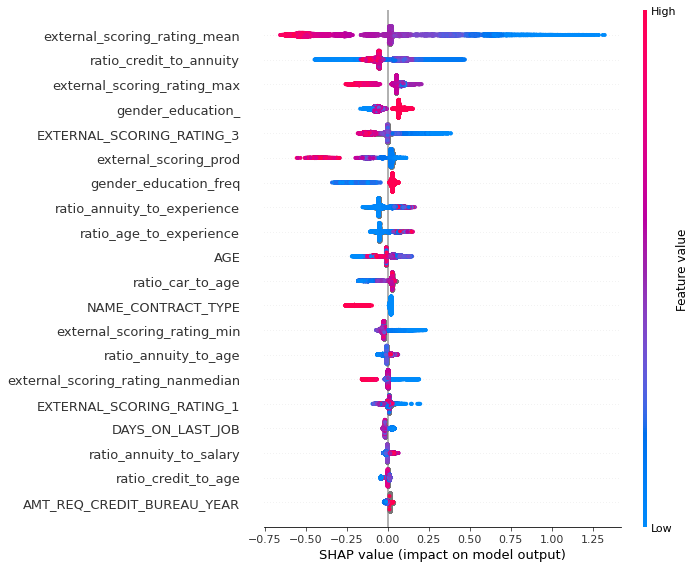

In [40]:
shap.summary_plot(shap_values, df_valid[SELECTED_FEATURE_NAMES_xgb])

In [41]:
model_xgb = run_model_xgb(features, i)
# [158]	train-auc:0.73648	valid-auc:0.72261	test-auc:0.71115

[0]	train-auc:0.60304	valid-auc:0.60438	test-auc:0.60028
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
[50]	train-auc:0.70753	valid-auc:0.69755	test-auc:0.68609
[100]	train-auc:0.72740	valid-auc:0.71642	test-auc:0.70133
[150]	train-auc:0.73573	valid-auc:0.72218	test-auc:0.70991
[200]	train-auc:0.73686	valid-auc:0.72321	test-auc:0.71103
Stopping. Best iteration:
[158]	train-auc:0.73648	valid-auc:0.72261	test-auc:0.71115



In [42]:
SELECTED_FEATURE_NAMES_xgb = features

* dart

In [43]:
model_xgb_dart = run_model_xgb_dart(SELECTED_FEATURE_NAMES_xgb, i)
# [413]	train-auc:0.73747	valid-auc:0.72365	test-auc:0.71025 

[0]	train-auc:0.60304	valid-auc:0.60438	test-auc:0.60028
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
[50]	train-auc:0.69052	valid-auc:0.68523	test-auc:0.67527
[100]	train-auc:0.71113	valid-auc:0.70070	test-auc:0.68931
[150]	train-auc:0.72212	valid-auc:0.71139	test-auc:0.69594
[200]	train-auc:0.72820	valid-auc:0.71654	test-auc:0.70149
[250]	train-auc:0.73272	valid-auc:0.71972	test-auc:0.70652
[300]	train-auc:0.73542	valid-auc:0.72202	test-auc:0.70826
[350]	train-auc:0.73642	valid-auc:0.72287	test-auc:0.70932
[400]	train-auc:0.73701	valid-auc:0.72349	test-auc:0.71000
[450]	train-auc:0.73749	valid-auc:0.72363	test-auc:0.71015
Stopping. Best iteration:
[413]	train-auc:0.73747	valid-auc:0.72365	test-auc:0.71025



* gblinear

In [44]:
model_xgb_linear = run_model_xgb_linear(SELECTED_FEATURE_NAMES_xgb, i)
# [995]	train-auc:0.67944	valid-auc:0.67178	test-auc:0.66190

[0]	train-auc:0.55588	valid-auc:0.54410	test-auc:0.52761
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
[500]	train-auc:0.67554	valid-auc:0.66804	test-auc:0.65992
[1000]	train-auc:0.67945	valid-auc:0.67177	test-auc:0.66184
Stopping. Best iteration:
[992]	train-auc:0.67942	valid-auc:0.67176	test-auc:0.66187



#### Base model LightGBM

In [45]:
model_lgb = run_model_lgb(SELECTED_FEATURE_NAMES_lgb, i)
#[671]	training's auc: 0.765193	valid_1's auc: 0.725737	valid_2's auc: 0.713897

Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.719541	valid_1's auc: 0.706359	valid_2's auc: 0.693098
[200]	training's auc: 0.729472	valid_1's auc: 0.713504	valid_2's auc: 0.698455
[300]	training's auc: 0.740197	valid_1's auc: 0.719792	valid_2's auc: 0.704773
[400]	training's auc: 0.748134	valid_1's auc: 0.722551	valid_2's auc: 0.709719
[500]	training's auc: 0.755425	valid_1's auc: 0.724312	valid_2's auc: 0.711888
[600]	training's auc: 0.761503	valid_1's auc: 0.725006	valid_2's auc: 0.713357
[700]	training's auc: 0.766549	valid_1's auc: 0.725571	valid_2's auc: 0.714301
Early stopping, best iteration is:
[671]	training's auc: 0.765193	valid_1's auc: 0.725737	valid_2's auc: 0.713897


In [46]:
explainer = shap.TreeExplainer(model_lgb)
shap_values = explainer.shap_values(df_valid[SELECTED_FEATURE_NAMES_lgb], y_valid)

In [47]:
shap_importances = pd.DataFrame(shap_values[1].mean(axis=0), SELECTED_FEATURE_NAMES_lgb, columns=['shap_values'])
shap_importances.loc[:, 'abs_shap_values'] = abs(shap_importances['shap_values'])
shap_importances = shap_importances.sort_values(by='abs_shap_values', ascending=False)

features = shap_importances[shap_importances['abs_shap_values'] > 5e-06].index.tolist()
len(features)

101

In [48]:
CATEGORICAL_FEATURE_NAMES_lgb = [i for i in features if i in CATEGORICAL_FEATURE_NAMES_lgb]

In [49]:
model_lgb = run_model_lgb(features, i)
#[708]	training's auc: 0.767096	valid_1's auc: 0.726251	valid_2's auc: 0.715608

Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.719761	valid_1's auc: 0.706462	valid_2's auc: 0.692973
[200]	training's auc: 0.729411	valid_1's auc: 0.713513	valid_2's auc: 0.698704
[300]	training's auc: 0.740177	valid_1's auc: 0.719645	valid_2's auc: 0.704514
[400]	training's auc: 0.748164	valid_1's auc: 0.722573	valid_2's auc: 0.710341
[500]	training's auc: 0.755117	valid_1's auc: 0.724241	valid_2's auc: 0.712563
[600]	training's auc: 0.761253	valid_1's auc: 0.725653	valid_2's auc: 0.714005
[700]	training's auc: 0.766663	valid_1's auc: 0.726298	valid_2's auc: 0.715331
Early stopping, best iteration is:
[708]	training's auc: 0.767096	valid_1's auc: 0.726251	valid_2's auc: 0.715608


In [50]:
SELECTED_FEATURE_NAMES_lgb = features

* dart

In [51]:
model_lgb_dart = run_model_lgb_dart(SELECTED_FEATURE_NAMES_lgb, i)
# [2000]	training's auc: 0.857116	valid_1's auc: 0.720452	valid_2's auc: 0.716447 0.5 0.3 lr 0.05 stop 20

[500]	training's auc: 0.75521	valid_1's auc: 0.722591	valid_2's auc: 0.710622
[1000]	training's auc: 0.798561	valid_1's auc: 0.724678	valid_2's auc: 0.714383
[1500]	training's auc: 0.832232	valid_1's auc: 0.723231	valid_2's auc: 0.715568
[2000]	training's auc: 0.857116	valid_1's auc: 0.720452	valid_2's auc: 0.716447


#### Base model Catboost

In [52]:
model_cb = run_model_cb(SELECTED_FEATURE_NAMES_cb, i)
# bestTest = 0.7118630863
# bestIteration = 613

0:	test: 0.6159018	test1: 0.6104511	best: 0.6104511 (0)	total: 574ms	remaining: 47m 47s
100:	test: 0.7129756	test1: 0.7002038	best: 0.7002038 (100)	total: 20.7s	remaining: 16m 45s
200:	test: 0.7203491	test1: 0.7075849	best: 0.7075870 (199)	total: 39.9s	remaining: 15m 51s
300:	test: 0.7223720	test1: 0.7091434	best: 0.7092583 (298)	total: 58.1s	remaining: 15m 7s
400:	test: 0.7240360	test1: 0.7102587	best: 0.7102587 (400)	total: 1m 14s	remaining: 14m 14s
500:	test: 0.7245415	test1: 0.7112093	best: 0.7112101 (496)	total: 1m 32s	remaining: 13m 54s
600:	test: 0.7246919	test1: 0.7117751	best: 0.7117777 (595)	total: 1m 47s	remaining: 13m 4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7118630863
bestIteration = 613

Shrink model to first 614 iterations.


In [53]:
shap_values_cb = model_cb.get_feature_importance(data=Pool(data=df_valid[SELECTED_FEATURE_NAMES_cb],
                                                           label=y_valid, cat_features=CATEGORICAL_FEATURE_NAMES), 
                                                 fstr_type='ShapValues',
                                                 prettified=True)

In [54]:
a = shap_values_cb.mean(axis=0)
features = [SELECTED_FEATURE_NAMES_cb[i] for i in a[abs(a) > 3e-04].index[:-1]]
features = [i for i in features if i not in CATEGORICAL_FEATURE_NAMES] + CATEGORICAL_FEATURE_NAMES
len(features)

75

In [55]:
model_cb = run_model_cb(features, i)
# bestTest = 0.7120212334
# bestIteration = 469

0:	test: 0.6702045	test1: 0.6508507	best: 0.6508507 (0)	total: 159ms	remaining: 13m 14s
100:	test: 0.7126078	test1: 0.6991399	best: 0.6992243 (99)	total: 15.6s	remaining: 12m 36s
200:	test: 0.7205548	test1: 0.7058374	best: 0.7058374 (200)	total: 30.6s	remaining: 12m 10s
300:	test: 0.7233776	test1: 0.7093241	best: 0.7093399 (299)	total: 44.8s	remaining: 11m 40s
400:	test: 0.7247165	test1: 0.7110121	best: 0.7110121 (400)	total: 58.6s	remaining: 11m 12s
500:	test: 0.7258057	test1: 0.7117947	best: 0.7120212 (469)	total: 1m 10s	remaining: 10m 35s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7120212334
bestIteration = 469

Shrink model to first 470 iterations.


In [56]:
SELECTED_FEATURE_NAMES_cb = features

#### Base model Random Forest

In [57]:
model_rf = run_model_rf(SELECTED_FEATURE_NAMES_rf, i)
#roc_auc_score train = 0.7385341672414412
#roc_auc_score test = 0.7049417994626845

roc_auc_score train = 0.7385341672414412
roc_auc_score test = 0.7049417994626845


In [58]:
explainer = shap.TreeExplainer(model_rf)
shap_values = explainer.shap_values(df_valid[SELECTED_FEATURE_NAMES_rf], y_valid)

In [59]:
shap_importances = pd.DataFrame(shap_values[1].mean(axis=0), SELECTED_FEATURE_NAMES_rf, columns=['shap_values'])
shap_importances.loc[:, 'abs_shap_values'] = abs(shap_importances['shap_values'])
shap_importances = shap_importances.sort_values(by='abs_shap_values', ascending=False)

features = shap_importances[shap_importances['abs_shap_values'] > 1e-05].index.tolist()
len(features)

123

In [60]:
model_rf = run_model_rf(features, i)
# roc_auc_score train = 0.6654171034486742
# roc_auc_score test = 0.6447353289036946 

roc_auc_score train = 0.7379033097512668
roc_auc_score test = 0.7054706148754486


In [61]:
SELECTED_FEATURE_NAMES_rf = features

In [62]:
gc.collect()

184

### 9. Ансамблирование моделей

#### XGBoost

In [63]:
def cross_validation_xgb(i):
    ind_cv = n_fold_cv_ind(i)
    estimators, folds_scores = [], []
    oof_preds = np.zeros(train.shape[0])
    for fold, key in enumerate(ind_cv):
        print(f'Fold {fold + 1}')
        train_ind, valid_ind = ind_cv[key]
        df_train, df_valid = train.loc[train_ind], train.loc[valid_ind]
        y_train, y_valid = train.loc[train_ind, TARGET_NAME], train.loc[valid_ind, TARGET_NAME]

        WOE_features = WOEFeatures(CATEGORICAL_FEATURE_NAMES, bin_splits)
        df_train = WOE_features.fit_fransform(df_train[features_], y_train)
        df_valid = WOE_features.fit_fransform(df_valid[features_])

        dtrain = xgb.DMatrix(data=df_train[SELECTED_FEATURE_NAMES_xgb], label=y_train)
        dvalid = xgb.DMatrix(data=df_valid[SELECTED_FEATURE_NAMES_xgb], label=y_valid)

        params_xgb = {"booster": "gbtree", 
                      "objective": "binary:logistic", 
                      "eval_metric": "auc", 
                      "learning_rate": 0.05,  
                      "reg_lambda": 100, 
                      "max_depth": 4, 
                      "gamma": 10, 
                      "nthread": 6, 
                      "seed": 27} 

        model_xgb = xgb.train(params=params_xgb,
                              dtrain=dtrain,
                              num_boost_round=1000,
                              early_stopping_rounds=50,
                              evals=[(dtrain, "train"), (dvalid, "valid")],
                              verbose_eval=50,
                              maximize=True)

        oof_preds[valid_ind] = model_xgb.predict(dvalid)
        score = roc_auc_score(y_valid, oof_preds[valid_ind])        
        folds_scores.append(round(score, 5))
        estimators.append(model_xgb)
        
    score = roc_auc_score(train[TARGET_NAME], oof_preds)    
    print(f'OOF score = {round(score, 5)}')    
    return estimators, oof_preds, folds_scores

In [64]:
def cross_validation_xgb_dart(i):
    ind_cv = n_fold_cv_ind(i)
    estimators, folds_scores = [], []
    oof_preds = np.zeros(train.shape[0])
    for fold, key in enumerate(ind_cv):
        print(f'Fold {fold + 1}')
        train_ind, valid_ind = ind_cv[key]
        df_train, df_valid = train.loc[train_ind], train.loc[valid_ind]
        y_train, y_valid = train.loc[train_ind, TARGET_NAME], train.loc[valid_ind, TARGET_NAME]

        WOE_features = WOEFeatures(CATEGORICAL_FEATURE_NAMES, bin_splits)
        df_train = WOE_features.fit_fransform(df_train[features_], y_train)
        df_valid = WOE_features.fit_fransform(df_valid[features_])

        dtrain = xgb.DMatrix(data=df_train[SELECTED_FEATURE_NAMES_xgb], label=y_train)
        dvalid = xgb.DMatrix(data=df_valid[SELECTED_FEATURE_NAMES_xgb], label=y_valid)

        params_xgb = {"booster": "dart", 
                      "objective": "binary:logistic", 
                      "eval_metric": "auc", 
                      "learning_rate": 0.05,
                      "skip_drop": 0.5,
                      "rate_drop": 0.5,
                      "reg_lambda": 100, 
                      "max_depth": 4, 
                      "gamma": 10, 
                      "nthread": 6, 
                      "seed": 27} 

        model_xgb = xgb.train(params=params_xgb,
                              dtrain=dtrain,
                              num_boost_round=1000,
                              early_stopping_rounds=50,
                              evals=[(dtrain, "train"), (dvalid, "valid")],
                              verbose_eval=50,
                              maximize=True)

        oof_preds[valid_ind] = model_xgb.predict(dvalid)
        score = roc_auc_score(y_valid, oof_preds[valid_ind])        
        folds_scores.append(round(score, 5))
        estimators.append(model_xgb)
        
    score = roc_auc_score(train[TARGET_NAME], oof_preds)    
    print(f'OOF score = {round(score, 5)}')    
    return estimators, oof_preds, folds_scores

In [65]:
def cross_validation_xgb_linear(i):
    ind_cv = n_fold_cv_ind(i)
    estimators, folds_scores = [], []
    oof_preds = np.zeros(train.shape[0])
    for fold, key in enumerate(ind_cv):
        print(f'Fold {fold + 1}')
        train_ind, valid_ind = ind_cv[key]
        df_train, df_valid = train.loc[train_ind], train.loc[valid_ind]
        y_train, y_valid = train.loc[train_ind, TARGET_NAME], train.loc[valid_ind, TARGET_NAME]

        WOE_features = WOEFeatures(CATEGORICAL_FEATURE_NAMES, bin_splits)
        df_train = WOE_features.fit_fransform(df_train[features_], y_train)
        df_valid = WOE_features.fit_fransform(df_valid[features_])

        dtrain = xgb.DMatrix(data=df_train[SELECTED_FEATURE_NAMES_xgb], label=y_train)
        dvalid = xgb.DMatrix(data=df_valid[SELECTED_FEATURE_NAMES_xgb], label=y_valid)

        params_xgb = {"booster": "gblinear", 
                      "objective": "binary:logistic", 
                      "eval_metric": "auc", 
                      "learning_rate": 0.1,  
                      "reg_lambda": 100,
                      "nthread": 6, 
                      "seed": 27} 

        model_xgb = xgb.train(params=params_xgb,
                              dtrain=dtrain,
                              num_boost_round=2500,
                              early_stopping_rounds=20,
                              evals=[(dtrain, "train"), (dvalid, "valid")],
                              verbose_eval=500,
                              maximize=True)

        oof_preds[valid_ind] = model_xgb.predict(dvalid)
        score = roc_auc_score(y_valid, oof_preds[valid_ind])        
        folds_scores.append(round(score, 5))
        estimators.append(model_xgb)
        
    score = roc_auc_score(train[TARGET_NAME], oof_preds)    
    print(f'OOF score = {round(score, 5)}')    
    return estimators, oof_preds, folds_scores

In [66]:
i = 42
estimators_xgb, oof_preds_xgb, folds_scores_xgb = cross_validation_xgb(i)

Fold 1
[0]	train-auc:0.60484	valid-auc:0.60304
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[50]	train-auc:0.70520	valid-auc:0.69716
[100]	train-auc:0.72467	valid-auc:0.71706
[150]	train-auc:0.73308	valid-auc:0.72270
[200]	train-auc:0.73404	valid-auc:0.72317
Stopping. Best iteration:
[170]	train-auc:0.73404	valid-auc:0.72317

Fold 2
[0]	train-auc:0.60003	valid-auc:0.60112
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[50]	train-auc:0.70344	valid-auc:0.69997
[100]	train-auc:0.72408	valid-auc:0.72104
[150]	train-auc:0.73105	valid-auc:0.72685
[200]	train-auc:0.73233	valid-auc:0.72743
Stopping. Best iteration:
[159]	train-auc:0.73203	valid-auc:0.72751

Fold 3
[0]	train-auc:0.59929	valid-auc:0.60030
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train unti

In [67]:
i = 27
estimators_xgb_dart, oof_preds_xgb_dart, folds_scores_xgb_dart = cross_validation_xgb_dart(i)

Fold 1
[0]	train-auc:0.60056	valid-auc:0.59742
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[50]	train-auc:0.69609	valid-auc:0.69228
[100]	train-auc:0.71483	valid-auc:0.70800
[150]	train-auc:0.72372	valid-auc:0.71581
[200]	train-auc:0.72942	valid-auc:0.71894
[250]	train-auc:0.73218	valid-auc:0.72036
[300]	train-auc:0.73382	valid-auc:0.72074
Stopping. Best iteration:
[282]	train-auc:0.73357	valid-auc:0.72087

Fold 2
[0]	train-auc:0.60033	valid-auc:0.61554
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[50]	train-auc:0.69235	valid-auc:0.70111
[100]	train-auc:0.71242	valid-auc:0.71732
[150]	train-auc:0.72105	valid-auc:0.72437
[200]	train-auc:0.72663	valid-auc:0.72720
[250]	train-auc:0.72967	valid-auc:0.72937
[300]	train-auc:0.73156	valid-auc:0.73045
Stopping. Best iteration:
[287]	train-auc:0.73145

In [68]:
i = 16
estimators_xgb_linear, oof_preds_xgb_linear, folds_scores_xgb_linear = cross_validation_xgb_linear(i)

Fold 1
[0]	train-auc:0.54114	valid-auc:0.53630
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[500]	train-auc:0.67119	valid-auc:0.67649
Stopping. Best iteration:
[764]	train-auc:0.67414	valid-auc:0.67830

Fold 2
[0]	train-auc:0.55509	valid-auc:0.55349
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[500]	train-auc:0.67319	valid-auc:0.67179
Stopping. Best iteration:
[617]	train-auc:0.67502	valid-auc:0.67232

Fold 3
[0]	train-auc:0.54241	valid-auc:0.55501
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[500]	train-auc:0.67327	valid-auc:0.67343
[1000]	train-auc:0.67634	valid-auc:0.67866
[1500]	train-auc:0.67690	valid-auc:0.67962
[2000]	train-auc:0.67709	valid-auc:0.68006
[2499]	train-auc:0.67719	valid-auc:0.

#### LightGBM

In [69]:
def cross_validation_lgb(i):
    ind_cv = n_fold_cv_ind(i)
    estimators, folds_scores = [], []
    oof_preds = np.zeros(train.shape[0])
    for fold, key in enumerate(ind_cv):
        print(f'Fold {fold + 1}')
        train_ind, valid_ind = ind_cv[key]
        df_train, df_valid = train.loc[train_ind], train.loc[valid_ind]
        y_train, y_valid = train.loc[train_ind, TARGET_NAME], train.loc[valid_ind, TARGET_NAME]

        WOE_features = WOEFeatures(CATEGORICAL_FEATURE_NAMES, bin_splits)
        df_train = WOE_features.fit_fransform(df_train[features_], y_train)
        df_valid = WOE_features.fit_fransform(df_valid[features_])
        
        dtrain = lgb.Dataset(data=df_train[SELECTED_FEATURE_NAMES_lgb], label=y_train,
                             categorical_feature=CATEGORICAL_FEATURE_NAMES_lgb)
        dvalid = lgb.Dataset(data=df_valid[SELECTED_FEATURE_NAMES_lgb], label=y_valid,
                             categorical_feature=CATEGORICAL_FEATURE_NAMES_lgb)

        params_lgb = {"boosting_type": "gbdt",
                      "objective": "binary",
                      "metric": "auc",
                      "num_boost_round": 10000, 
                      "learning_rate": 0.01,    
                      "class_weight": 'balanced',
                      "max_depth": 3,
                      "n_estimators": 5000,
                      "n_jobs": 6,
                      "seed": 36}  

        model_lgb = lgb.train(params=params_lgb,
                          train_set=dtrain,  
                          valid_sets=[dtrain, dvalid],
                          categorical_feature=CATEGORICAL_FEATURE_NAMES_lgb, 
                          verbose_eval=100,
                          early_stopping_rounds=50)
        
        oof_preds[valid_ind] = model_lgb.predict(df_valid[SELECTED_FEATURE_NAMES_lgb])
        score = roc_auc_score(y_valid, oof_preds[valid_ind])        
        folds_scores.append(round(score, 5))
        estimators.append(model_lgb)
        
    score = roc_auc_score(train[TARGET_NAME], oof_preds)    
    print(f'OOF score = {round(score, 5)}')    
    return estimators, oof_preds, folds_scores

In [70]:
def cross_validation_lgb_dart(i):
    ind_cv = n_fold_cv_ind(i)
    estimators, folds_scores = [], []
    oof_preds = np.zeros(train.shape[0])
    for fold, key in enumerate(ind_cv):
        print(f'Fold {fold + 1}')
        train_ind, valid_ind = ind_cv[key]
        df_train, df_valid = train.loc[train_ind], train.loc[valid_ind]
        y_train, y_valid = train.loc[train_ind, TARGET_NAME], train.loc[valid_ind, TARGET_NAME]

        WOE_features = WOEFeatures(CATEGORICAL_FEATURE_NAMES, bin_splits)
        df_train = WOE_features.fit_fransform(df_train[features_], y_train)
        df_valid = WOE_features.fit_fransform(df_valid[features_])
        
        dtrain = lgb.Dataset(data=df_train[SELECTED_FEATURE_NAMES_lgb], label=y_train,
                             categorical_feature=CATEGORICAL_FEATURE_NAMES_lgb)
        dvalid = lgb.Dataset(data=df_valid[SELECTED_FEATURE_NAMES_lgb], label=y_valid,
                             categorical_feature=CATEGORICAL_FEATURE_NAMES_lgb)

        params_lgb = {"boosting_type": "dart",
                      "objective": "binary",
                      "metric": "auc",
                      "num_boost_round": 10000,  
                      "learning_rate": 0.05,
                      "skip_drop": 0.5,
                      "rate_drop": 0.3,  
                      "class_weight": 'balanced',
                      "max_depth": 3,
                      "n_estimators": 1500,
                      "n_jobs": 6,
                      "seed": i}   

        model_lgb = lgb.train(params=params_lgb,
                          train_set=dtrain,  
                          valid_sets=[dtrain, dvalid],
                          categorical_feature=CATEGORICAL_FEATURE_NAMES_lgb, 
                          verbose_eval=100,
                          early_stopping_rounds=20)
        
        oof_preds[valid_ind] = model_lgb.predict(df_valid[SELECTED_FEATURE_NAMES_lgb])
        score = roc_auc_score(y_valid, oof_preds[valid_ind])        
        folds_scores.append(round(score, 5))
        estimators.append(model_lgb)
        
    score = roc_auc_score(train[TARGET_NAME], oof_preds)    
    print(f'OOF score = {round(score, 5)}')    
    return estimators, oof_preds, folds_scores

In [71]:
i = 36
estimators_lgb, oof_preds_lgb, folds_scores_lgb = cross_validation_lgb(i)

Fold 1
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.709744	valid_1's auc: 0.688632
[200]	training's auc: 0.717933	valid_1's auc: 0.696475
[300]	training's auc: 0.726339	valid_1's auc: 0.704439
[400]	training's auc: 0.732277	valid_1's auc: 0.70674
[500]	training's auc: 0.73642	valid_1's auc: 0.709054
[600]	training's auc: 0.739631	valid_1's auc: 0.710824
[700]	training's auc: 0.742894	valid_1's auc: 0.712111
[800]	training's auc: 0.745352	valid_1's auc: 0.713397
[900]	training's auc: 0.747508	valid_1's auc: 0.714599
[1000]	training's auc: 0.749736	valid_1's auc: 0.715268
[1100]	training's auc: 0.752035	valid_1's auc: 0.715399
[1200]	training's auc: 0.754176	valid_1's auc: 0.715599
[1300]	training's auc: 0.756217	valid_1's auc: 0.715753
Early stopping, best iteration is:
[1345]	training's auc: 0.757202	valid_1's auc: 0.715975
Fold 2
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.706959	valid_1's auc: 0.700388
[

In [72]:
i = 29
estimators_lgb_dart, oof_preds_lgb_dart, folds_scores_lgb_dart = cross_validation_lgb_dart(i)

Fold 1
[100]	training's auc: 0.70439	valid_1's auc: 0.703657
[200]	training's auc: 0.710387	valid_1's auc: 0.709477
[300]	training's auc: 0.722547	valid_1's auc: 0.715399
[400]	training's auc: 0.729658	valid_1's auc: 0.717395
[500]	training's auc: 0.73742	valid_1's auc: 0.719558
[600]	training's auc: 0.741236	valid_1's auc: 0.720848
[700]	training's auc: 0.745032	valid_1's auc: 0.721426
[800]	training's auc: 0.748976	valid_1's auc: 0.722747
[900]	training's auc: 0.751801	valid_1's auc: 0.722544
[1000]	training's auc: 0.75498	valid_1's auc: 0.722833
[1100]	training's auc: 0.758063	valid_1's auc: 0.72357
[1200]	training's auc: 0.761055	valid_1's auc: 0.723435
[1300]	training's auc: 0.763788	valid_1's auc: 0.723902
[1400]	training's auc: 0.767673	valid_1's auc: 0.724168
[1500]	training's auc: 0.771923	valid_1's auc: 0.724265
Fold 2
[100]	training's auc: 0.703358	valid_1's auc: 0.711002
[200]	training's auc: 0.707788	valid_1's auc: 0.71258
[300]	training's auc: 0.720405	valid_1's auc: 0.72

#### CatBoost

In [73]:
def cross_validation_cb(i):
    ind_cv = n_fold_cv_ind(i)
    estimators, folds_scores = [], []
    oof_preds = np.zeros(train.shape[0])
    for fold, key in enumerate(ind_cv):
        print(f'Fold {fold + 1}')
        train_ind, valid_ind = ind_cv[key]
        df_train, df_valid = train.loc[train_ind], train.loc[valid_ind]
        y_train, y_valid = train.loc[train_ind, TARGET_NAME], train.loc[valid_ind, TARGET_NAME]

        WOE_features = WOEFeatures(CATEGORICAL_FEATURE_NAMES, bin_splits)
        df_train = WOE_features.fit_fransform(df_train[features_], y_train)
        df_valid = WOE_features.fit_fransform(df_valid[features_])
        
        dtrain = Pool(data=df_train[SELECTED_FEATURE_NAMES_cb], label=y_train,
                      cat_features=CATEGORICAL_FEATURE_NAMES)
        dvalid = Pool(data=df_valid[SELECTED_FEATURE_NAMES_cb], label=y_valid,
                      cat_features=CATEGORICAL_FEATURE_NAMES)

        params_cb = {"n_estimators":5000,
                     "loss_function": "Logloss",
                     "eval_metric": "AUC",
                     "task_type": "CPU",
                     "max_bin": 30,
                     "early_stopping_rounds": 50,
                     "verbose": 100,
                     "max_depth": 5,
                     "l2_leaf_reg": 80, 
                     "thread_count": 6,
                     "random_seed": 51} 

        model_cb = CatBoostClassifier(**params_cb)
        model_cb.fit(dtrain, eval_set=[dvalid])
        
        oof_preds[valid_ind] = model_cb.predict_proba(df_valid[SELECTED_FEATURE_NAMES_cb])[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_ind])        
        folds_scores.append(round(score, 5))
        estimators.append(model_cb)
        
    score = roc_auc_score(train[TARGET_NAME], oof_preds)    
    print(f'OOF score = {round(score, 5)}')    
    return estimators, oof_preds, folds_scores

In [74]:
i = 51
estimators_cb, oof_preds_cb, folds_scores_cb = cross_validation_cb(i)

Fold 1
0:	test: 0.6448901	best: 0.6448901 (0)	total: 178ms	remaining: 14m 48s
100:	test: 0.7163293	best: 0.7163293 (100)	total: 15.8s	remaining: 12m 48s
200:	test: 0.7230499	best: 0.7231301 (199)	total: 31.3s	remaining: 12m 27s
300:	test: 0.7247521	best: 0.7247530 (299)	total: 46.8s	remaining: 12m 10s
400:	test: 0.7258376	best: 0.7258471 (399)	total: 1m 2s	remaining: 11m 51s
500:	test: 0.7269491	best: 0.7269967 (496)	total: 1m 16s	remaining: 11m 28s
600:	test: 0.7270584	best: 0.7271511 (558)	total: 1m 31s	remaining: 11m 6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.727151087
bestIteration = 558

Shrink model to first 559 iterations.
Fold 2
0:	test: 0.6473517	best: 0.6473517 (0)	total: 176ms	remaining: 14m 37s
100:	test: 0.7152005	best: 0.7152005 (100)	total: 16.3s	remaining: 13m 12s
200:	test: 0.7225885	best: 0.7225885 (200)	total: 32.1s	remaining: 12m 47s
300:	test: 0.7252308	best: 0.7252308 (300)	total: 47.7s	remaining: 12m 24s
400:	test: 0.7264931	best: 0.72

#### Random Forest

In [75]:
def cross_validation_rf(i):
    ind_cv = n_fold_cv_ind(i)
    estimators, folds_scores = [], []
    oof_preds = np.zeros(train.shape[0])
    for fold, key in enumerate(ind_cv):
        print(f'Fold {fold + 1}')
        train_ind, valid_ind = ind_cv[key]
        df_train, df_valid = train.loc[train_ind], train.loc[valid_ind]
        y_train, y_valid = train.loc[train_ind, TARGET_NAME], train.loc[valid_ind, TARGET_NAME]

        WOE_features = WOEFeatures(CATEGORICAL_FEATURE_NAMES, bin_splits)
        df_train = WOE_features.fit_fransform(df_train[features_], y_train)
        df_valid = WOE_features.fit_fransform(df_valid[features_])
        
        params_rf = {"n_estimators": 300,
                     "max_depth": 6,
                     "class_weight": 'balanced_subsample', 
                     "random_state": 42}  

        model_rf = RandomForestClassifier(**params_rf)
        model_rf.fit(df_train[SELECTED_FEATURE_NAMES_rf].fillna(-99), y_train)
        
        y_train_pred = model_rf.predict_proba(df_train[SELECTED_FEATURE_NAMES_rf].fillna(-99))[:, 1]
        train_score = roc_auc_score(y_train, y_train_pred)        
        
        oof_preds[valid_ind] = model_rf.predict_proba(df_valid[SELECTED_FEATURE_NAMES_rf].fillna(-99))[:, 1]         
        score = roc_auc_score(y_valid, oof_preds[valid_ind])
        print(f'train score = {round(train_score, 5)}, valid score = {round(score, 5)}')
        
        folds_scores.append(round(score, 5))
        estimators.append(model_rf)        
        
    score = roc_auc_score(train[TARGET_NAME], oof_preds)    
    print(f'OOF score = {round(score, 5)}')    
    return estimators, oof_preds, folds_scores

In [76]:
i = 16
estimators_rf, oof_preds_rf, folds_scores_rf = cross_validation_rf(i)

Fold 1
train score = 0.7329, valid score = 0.711
Fold 2
train score = 0.73387, valid score = 0.70837
Fold 3
train score = 0.73302, valid score = 0.71403
Fold 4
train score = 0.73284, valid score = 0.70729
Fold 5
train score = 0.73509, valid score = 0.70345
OOF score = 0.70829


In [77]:
cols = ['xgb', 'xgb_dart', 'xgb_linear', 'lgb', 'lgb_dart', 'cb', 'rf']
OOF_results = pd.DataFrame([oof_preds_xgb, oof_preds_xgb_dart, oof_preds_xgb_linear,
                            oof_preds_lgb, oof_preds_lgb_dart, 
                            oof_preds_cb, oof_preds_rf], index=cols).T

In [78]:
OOF_results.corr()

,xgb,xgb_dart,xgb_linear,lgb,lgb_dart,cb,rf
xgb,1.000000,0.990437,0.671738,0.978496,0.960924,0.968528,0.834602
xgb_dart,0.990437,1.000000,0.672186,0.978991,0.961527,0.969063,0.835103
xgb_linear,0.671738,0.672186,1.000000,0.663783,0.648102,0.668635,0.704537
lgb,0.978496,0.978991,0.663783,1.000000,0.964891,0.966305,0.838494
lgb_dart,0.960924,0.961527,0.648102,0.964891,1.000000,0.958012,0.816555
cb,0.968528,0.969063,0.668635,0.966305,0.958012,1.000000,0.825806
rf,0.834602,0.835103,0.704537,0.838494,0.816555,0.825806,1.000000


In [80]:
scores = [folds_scores_xgb, folds_scores_xgb_dart, folds_scores_xgb_linear,
          folds_scores_lgb, folds_scores_lgb_dart, folds_scores_cb, folds_scores_rf]
for i, score in enumerate(scores):
    print(f'score {cols[i]}:\t{score}')

score xgb:	[0.72317, 0.72743, 0.72017, 0.71679, 0.72393]
score xgb_dart:	[0.72073, 0.73045, 0.7141, 0.72825, 0.71727]
score xgb_linear:	[0.6783, 0.6723, 0.6802, 0.67514, 0.67445]
score lgb:	[0.71598, 0.72272, 0.72455, 0.72893, 0.72872]
score lgb_dart:	[0.72426, 0.72975, 0.72111, 0.72705, 0.72512]
score cb:	[0.72715, 0.72721, 0.73258, 0.72783, 0.71956]
score rf:	[0.711, 0.70837, 0.71403, 0.70729, 0.70345]


In [116]:
predictions = pd.DataFrame()
y_pred = 0
for model in estimators_xgb:
    y_pred += model.predict(xgb.DMatrix(data=test_final[SELECTED_FEATURE_NAMES_xgb]))
y_pred /= len(estimators_xgb)
predictions.loc[:, 'xgb'] = y_pred

y_pred = 0
for model in estimators_xgb_dart:
    y_pred += model.predict(xgb.DMatrix(data=test_final[SELECTED_FEATURE_NAMES_xgb]))
y_pred /= len(estimators_xgb_dart)
predictions.loc[:, 'xgb_dart'] = y_pred

y_pred = 0
for model in estimators_xgb_linear:
    y_pred += model.predict(xgb.DMatrix(data=test_final[SELECTED_FEATURE_NAMES_xgb]))
y_pred /= len(estimators_xgb_linear)
predictions.loc[:, 'xgb_linear'] = y_pred

y_pred = 0
for model in estimators_lgb:
    y_pred = model.predict(test_final[SELECTED_FEATURE_NAMES_lgb])
y_pred /= len(estimators_lgb)
predictions.loc[:, 'lgb'] = y_pred

y_pred = 0
for model in estimators_lgb_dart:
    y_pred = model.predict(test_final[SELECTED_FEATURE_NAMES_lgb])
y_pred /= len(estimators_lgb_dart)
predictions.loc[:, 'lgb_dart'] = y_pred

y_pred = 0
for model in estimators_cb:
    y_pred = model.predict_proba(test_final[SELECTED_FEATURE_NAMES_cb])[:, 1]
y_pred /= len(estimators_cb)
predictions.loc[:, 'cb'] = y_pred

y_pred = 0
for model in estimators_rf:
    y_pred = model.predict_proba(test_final[SELECTED_FEATURE_NAMES_rf].fillna(-99))[:, 1]
y_pred /= len(estimators_rf)
predictions.loc[:, 'rf'] = y_pred

In [117]:
predictions.corr()

,xgb,xgb_dart,xgb_linear,lgb,lgb_dart,cb,rf
xgb,1.000000,0.999333,0.674728,0.982167,0.966214,0.969461,0.835335
xgb_dart,0.999333,1.000000,0.676146,0.982403,0.966824,0.969955,0.835373
xgb_linear,0.674728,0.676146,1.000000,0.661773,0.645555,0.673193,0.703720
lgb,0.982167,0.982403,0.661773,1.000000,0.969541,0.963599,0.828767
lgb_dart,0.966214,0.966824,0.645555,0.969541,1.000000,0.954693,0.813013
cb,0.969461,0.969955,0.673193,0.963599,0.954693,1.000000,0.822605
rf,0.835335,0.835373,0.703720,0.828767,0.813013,0.822605,1.000000


In [118]:
def transform_predictions(predictions):
    predictions.loc[:, 'mean_xgb_lgb'] =\
             predictions[['xgb', 'lgb']].mean(axis=1).values    
    predictions.loc[:, 'mean_xgb_lgb_cb'] =\
                 predictions[['xgb', 'lgb', 'cb']].mean(axis=1).values    
    predictions.loc[:, 'mean_xgb_lgb_rf',] =\
             predictions[['xgb', 'lgb', 'rf']].mean(axis=1).values    
    predictions.loc[:, 'mean_xgb_xgb_linear_lgb',] =\
             predictions[['xgb', 'xgb_linear', 'lgb']].mean(axis=1).values

    # геометриеское среднее
    predictions.loc[:, 'gmean_xgb_lgb'] =\
                 gmean(predictions[['xgb', 'lgb']],axis=1)
    predictions.loc[:, 'gmean_xgb_lgb_cb'] =\
                 gmean(predictions[['xgb', 'lgb', 'cb']],axis=1)
    predictions.loc[:, 'gmean_xgb_lgb_rf'] =\
                 gmean(predictions[['xgb', 'lgb', 'rf']],axis=1)
    predictions.loc[:, 'gmean_xgb_linear_lgb'] =\
                 gmean(predictions[['xgb', 'xgb_linear', 'lgb']],axis=1)
    
    # усреднение рангов   
    predictions.loc[:, 'mean_rank_xgb_lgb'] =\
             predictions[['xgb', 'lgb']].rank(axis=0).mean(axis=1).values    
    predictions.loc[:, 'mean_rank_xgb_lgb_cb'] =\
                 predictions[['xgb', 'lgb', 'cb']].rank(axis=0).mean(axis=1).values    
    predictions.loc[:, 'mean_rank_xgb_lgb_rf',] =\
             predictions[['xgb', 'lgb', 'rf']].rank(axis=0).mean(axis=1).values    
    predictions.loc[:, 'mean_rank_xgb_xgb_linear_lgb',] =\
             predictions[['xgb', 'xgb_linear', 'lgb']].rank(axis=0).mean(axis=1).values
    
    return predictions  

In [119]:
OOF_results = transform_predictions(OOF_results)
predictions = transform_predictions(predictions)

In [120]:
OOF_results.to_csv(PATH + 'OOF_results.csv')
predictions.to_csv(PATH + 'predictions_test.csv')
#OOF_results = pd.read_csv(PATH + 'OOF_results.csv').set_index('APPLICATION_NUMBER')
#predictions = pd.read_csv(PATH + 'predictions.csv').set_index('APPLICATION_NUMBER')

#### roc_auc_score OOF_results

In [121]:
roc_auc = pd.DataFrame()
for y_pred in OOF_results.columns:
    roc_auc.loc[y_pred, 'roc_auc_score'] = roc_auc_score(train[TARGET_NAME], OOF_results[y_pred])
    
roc_auc 

,roc_auc_score
xgb,0.721720
xgb_dart,0.721481
xgb_linear,0.675377
lgb,0.723328
lgb_dart,0.725173
cb,0.726432
rf,0.708294
mean_xgb_lgb,0.723408
mean_xgb_lgb_cb,0.725874
mean_xgb_lgb_rf,0.716494


### 6. Построение прогнозов на полном наборе данных

In [122]:
from sklearn.model_selection import train_test_split

In [123]:
results_train, results_valid, results_y_train, results_y_valid = \
train_test_split(OOF_results, train[TARGET_NAME], 
                 test_size=0.3, stratify=train[TARGET_NAME], random_state=42)

results_valid, results_test, results_y_valid,  results_y_test = \
train_test_split(results_valid, results_y_valid, 
                 test_size=0.5, stratify=results_y_valid, random_state=42)

params_rf = {"n_estimators": 300,
                     "max_depth": 6,
                     "class_weight": 'balanced_subsample', 
                     "random_state": 42}  

model_rf = RandomForestClassifier(**params_rf)
model_rf.fit(results_train, results_y_train)
y_pred_ = model_cb.predict_proba(results_valid)[:, 1] 

y_train_pred = model_rf.predict_proba(results_train)[:, 1]
train_score = roc_auc_score(results_y_train, y_train_pred) 

y_valid_pred = model_rf.predict_proba(results_valid)[:, 1]
valid_score = roc_auc_score(results_y_valid, y_valid_pred)
        
y_test_pred = model_rf.predict_proba(results_test)[:, 1]
test_score = roc_auc_score(results_y_test, y_test_pred)

print(f'train score = {round(train_score, 5)}, valid score = {round(valid_score, 5)}, test score = {round(test_score, 5)}')
# train score = 0.72742, valid score = 0.7252, test score = 0.72573 2
# train score = 0.72869, valid score = 0.72661, test score = 0.72638 3
# train score = 0.733, valid score = 0.72835, test score = 0.72664 4
# train score = 0.73787, valid score = 0.72905, test score = 0.72718 5

train score = 0.74521, valid score = 0.7293, test score = 0.72744


In [126]:
df = test.copy()
#y_pred_final = model_rf.predict_proba(predictions)[:, 1]
#df.loc[:, 'TARGET'] = y_pred_final
y_pred_final = predictions['cb'].values
df.loc[:, 'TARGET'] = y_pred_final / y_pred_final.max()
y_final = df[['APPLICATION_NUMBER', 'TARGET']].groupby('APPLICATION_NUMBER').mean()
y_final.to_csv(PATH + 'predictions.csv')
y_final.head(2)

,TARGET
APPLICATION_NUMBER,
123423342,0.081331
123423343,0.061938


### 1. Обучить алгоритмы LightGBM и XGBoost, получить OOF прогнозы, оценить корреляцию прогнозов на обучающей выборке. Применить модели на тестовую выборку и оценить корреляцию.

На обучающей и тестовой выборках корреляция прогнозов LightGBM и XGBoost сопоставима: 0.9785 и 0.9817 соответственно.

### 2. Усреднить прогнозы с помощью арифмитического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации.

Каество комбиннации моделей может быть выше качества каждой модели, входящей в комбинацию. Среднее арифметическое дает лучший результат, чем среднее геометрическое.

### 3. Обучить CatBoost, получить OOF прогнозы и выполнить задание 1 для трех моделей.

Корреляция CatBoost с моделями LightGBM и XGBoost составляяяет 0.9685 с XGBoost и 0.9663 с LightGBM. Аналогичная ситуация на тестовой выборке: 0.9635 и 0.9639 соответсвтвенно.

### 4. Выполнить задание 2 для трех моделей.

Комбинация трех моделей дает более высокий результат, чем комбинация 2 моделей.

### 5. (опция) Объединить OOF-прогнозы для трех моделей и обучить алгоритм Логистической регрессии (и любой другой, на ваше усмотрение). Сделать выводы о достигаемом качестве, сравнить достигаемое качество с качеством отдельных моделей и моделей, полученных в п.2 и п.4.

Качество, достигаемое при использовании XGBoost ниже качества отдельной модели СatBoost .

### 6. (опция) Обучить алгоритм RandomForest (желательно подтюнить параметры) и добавить к построенным ранее моделям. Выполнить задание 5.

У алгоритма RandomForest самая низкая корреляция с другими моделями, должно быть, он вносит вклад в достигнутый результат, несмотря на относительно слабую индивидуальную эффективность.